In [1]:
import numpy as np 
import pandas as pd 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

Датасет - `bus_table.csv`
- `data` - дата
- `route` - название маршрута автобуса
- `direction` - направление маршрута
- `scheduled` - время прибыттия по расписанию
- `actual` - фактическое время прибытия

## Задание 1
Прочитайте файл, сохранив результаты в `df`. Посмотрите статистики и инфо.

In [5]:
df = pd.read_csv('bus_table.csv')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 39157 entries, 0 to 39156
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       39157 non-null  object
 1   route      39157 non-null  object
 2   direction  39157 non-null  object
 3   scheduled  38917 non-null  object
 4   actual     39157 non-null  object
dtypes: object(5)
memory usage: 1.8+ MB


,data,route,direction,scheduled,actual
count,39157,39157,39157,38917,39157
unique,63,3,2,1356,27633
top,2016-04-14,A,north,23:00:25,08:08:24
freq,693,13358,19686,64,8


## Задание 2
Вырежте пропушеные данные (сохраните их в DataFrame `df_null`, они вам еще понадобятся) и удалите их из `df`. Выведите размерность `df_null`.

In [7]:
df_copy = df.copy()
df_null = df_copy[df_copy.isna().any(axis=1)]
df.dropna(inplace=True)
df_null.shape

(240, 5)

## Задание 3
1. Добавьте столбец `table` дату/время прибытия автобусов по расписанию на остановку. 
2. Добавьте столбец `arrival` дату/временя актуального прибытия автобуса на остановку.


In [9]:
df['table'] = df['data'] + ' ' + df['scheduled']
df['table'] = df['table'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [10]:
df['arrival'] = df['data'] + ' ' + df['actual']
df['arrival'] = df['arrival'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [11]:
index_of_errors1 = df[(df['arrival'] - df['table']) > timedelta(hours=12)].index
df.loc[index_of_errors1, 'arrival'] = df['arrival'] - timedelta(days=1)

In [12]:
index_of_errors2 = df[(df['table'] - df['arrival']) > timedelta(hours=12)].index
df.loc[index_of_errors2, 'arrival'] = df['arrival'] + timedelta(days=1)

*будем считать, что нельзя ставить в расписание прибытие автобуса (одинакового пути и направления) в одно и то же время*

In [14]:
df.drop_duplicates(subset=['route', 'direction', 'table'], inplace=True)

## Задание 4
1. Найдите три самых часто встречаюшихся в расписании автобусов временных интервалов (естественно для каждой возможной пары номер маршрута-направление).

2. Добавьте в таблицу столбик `inteval` - интервал по расписаню между автобусами (естественно одного маршрута и направления) в МИНУТАХ.

3. Добавьте в таблицу столбик `arr_inteval` - интервал по фактическому между автобусами (естественно одного маршрута и направления) в МИНУТАХ.

In [16]:
df = df.set_index(['route', 'direction']).sort_values(['route', 'direction', 'table'])
df['interval'] = df['table'].diff()
df['interval'] = df['interval'].apply(lambda x: x.seconds / 60)
df.reset_index(inplace=True)

In [17]:
index_of_errors3 = df[(df['route'].shift(1) != df['route']) | (df['direction'].shift(1) != df['direction'])].index
df.loc[index_of_errors3, 'interval'] = np.nan

In [18]:
df = df.set_index(['route', 'direction']).sort_values(['route', 'direction', 'arrival'])
df['arr_interval'] = df['arrival'].diff()
df['arr_interval'] = df['arr_interval'].apply(lambda x: x.seconds / 60)
df.reset_index(inplace=True)

In [19]:
index_of_errors4 = df[(df['route'].shift(1) != df['route']) | (df['direction'].shift(1) != df['direction'])].index
df.loc[index_of_errors4, 'arr_interval'] = np.nan

In [20]:
temp = df.pivot_table(index=['route', 'direction', 'interval'], values='data', aggfunc='count').reset_index().set_index('interval')
temp.groupby(['route', 'direction'])['data'].nlargest(3)

route  direction  interval
A      north      12.0        1434
                  15.0        1377
                  7.0          756
       south      15.0        1453
                  12.0        1312
                  8.0          710
B      north      15.0        1507
                  12.0        1413
                  8.0         1141
       south      15.0        1391
                  12.0        1300
                  8.0         1159
C      north      10.0        1869
                  15.0         590
                  6.0          552
       south      10.0        1342
                  12.0        1087
                  15.0        1049
Name: data, dtype: int64

## Задание 5
Найдите время в минутах для опоздания авдобуса (+ задержка, - раньше расписания)

In [22]:
df['late'] = df['arrival'] - df['table']
df['late'] = df['late'].apply(lambda x: x.seconds / 60 + x.days * 24 * 60)

## Задание 6
1. Постройте максимально качественные гистограммы (или их аналоги) для разницы интервалов между автобусами для различных маршрутов и направлений.

2. Постройте максимально качественные гистограммы (или их аналоги) времени опоздания автобуса в зависимости от маршрута и направления.

   Увидели абсурд - возращаемся к началу и латаем код ;)
   *ps: да, увидела, автобус опаздывает на сутки))))*

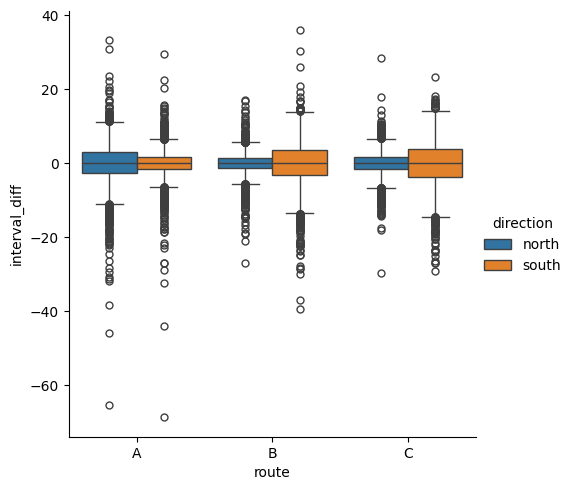

In [24]:
df['interval_diff'] = df['interval'] - df['arr_interval']
sns.catplot(kind='box', data=df, x='route', y='interval_diff', hue='direction');

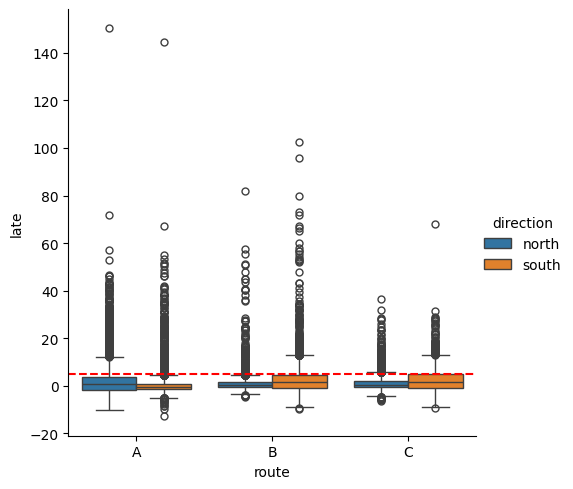

In [25]:
sns.catplot(kind='box', data=df, x='route', y='late', hue='direction')
plt.axhline(y=5, color='red', linestyle='--');

#### Можно, что либо сказать о маршрутах автобусов содержательно?

*По первому графику:*

*Более высокий межквартильный размах для автобусов А на север означает, что фактические интервалы прибытия этих автобусов более изменчивы, чем интервалы для автобусов В и С. То есть пассажирам автобусов А на север следует ожидать большей неопределенности. С другой стороны, если пассажиры едут на юг, то ситуация в точности обратная*

*Медиана около нуля предполагает, что нет значительных системных отклонений в исполнении расписания. Она указывает на то, что фактические интервалы прибытия автобусов, как правило, соответствуют запланированным*

*По второму графику:*

*Более высокий межквартильный размах для автобусов А на север означает, что время опоздания этих автобусов более изменчиво, чем опоздание автобусов В и С. То есть пассажиры, пользующиеся автобусами А на север, могут столкнуться с более значительными задержками или ранним прибытием. С другой стороны, если пассажиры едут на юг, то ситуация в точности обратная*

*Медиана около нуля говорит нам, что, в целом, система общественного транспорта работает довольно эффективно, так как большинство автобусов прибывают близко к запланированному времени (половина автобусов опаздывает не более, чем на 5 минут)*

**Скорее всего, депо находится на юге, так как опаздание автобусов в северном направлении больше соответсвует расписанию.**

## Задание финальное ... для тех кто может
Давайте попробуем заполнить пропущенные данные в расписании  - `df_null`. Как это сделать правильно?

In [29]:
df_null['arrival'] = df_null['data'] + ' ' + df_null['actual']
df_null['arrival'] = df_null['arrival'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
df_full = pd.concat([df, df_null], join='outer')

In [30]:
df_full.reset_index(drop=True, inplace=True)
df_full_sorted = df_full.reset_index().set_index(['route', 'direction']).sort_values(['route', 'direction', 'arrival'])
index_of_null = df_full_sorted[df_full_sorted['table'].isna()]['index'].values
df_full_sorted['table'] = df_full_sorted['table'].interpolate(method='linear',axis=0)
df_full_sorted = df_full_sorted.reset_index().set_index('index').sort_index()

In [31]:
temp = df_full_sorted.iloc[-240:]
temp['scheduled'] = temp['table'].apply(lambda x: x.strftime("%H:%M:%S"))
df_null['scheduled'] = temp['scheduled'].values
df_null.drop(columns='arrival', inplace=True)
df_null

,data,route,direction,scheduled,actual
383,2016-04-01,A,south,15:58:26,16:00:57
471,2016-03-31,A,south,15:28:26,15:28:05
588,2016-03-30,A,south,14:52:56,14:52:36
599,2016-03-30,A,south,15:14:56,15:12:06
685,2016-03-29,A,south,17:53:56,17:56:29
...,...,...,...,...,...
37327,2016-05-10,B,north,15:24:29,15:25:47
37328,2016-05-10,B,north,17:45:29,17:44:05
37570,2016-05-12,B,north,18:28:58,18:27:55
37670,2016-05-13,B,north,19:07:25,19:04:25
